## Exploratory Data Analysis (EDA) on Customer Bookings data for British Airways

We will explore the customer data first to get to know it better in depth.


In [149]:
# imports necessary modules
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV,  RepeatedStratifiedKFold

In [150]:
#read the csv
df = pd.read_csv("data/customer_booking.csv",  encoding="ISO-8859-1")

In [151]:
# first five rows
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [152]:
# shape of the data
df.shape

(50000, 14)

In [153]:
# detailed statistics
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [154]:
# information on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

### Sales Channel

In [155]:
# calculate the number of booking by using internet and phone
per_internet = df.sales_channel.value_counts().values[0]  / df.sales_channel.count() *100
per_mobile = df.sales_channel.value_counts().values[1]  / df.sales_channel.count() *100

In [156]:
print(f"Number of bookings done through internet: {per_internet} %")
print(f"Number of bookings done through phone call: {per_mobile} %")

Number of bookings done through internet: 88.764 %
Number of bookings done through phone call: 11.236 %


### Trip Type

In [157]:
# trip types in percentage
per_round = df.trip_type.value_counts().values[0]/ df.trip_type.count() *100
per_oneway = df.trip_type.value_counts().values[1]/ df.trip_type.count() *100
per_circle = df.trip_type.value_counts().values[2]/ df.trip_type.count() *100

In [158]:
print(f"Percentage of round trips: {per_round} %")
print(f"Percentage of One way trips: {per_oneway} %")
print(f"Percentage of circle trips: {per_circle} %")


Percentage of round trips: 98.994 %
Percentage of One way trips: 0.774 %
Percentage of circle trips: 0.232 %


### Purchase Lead

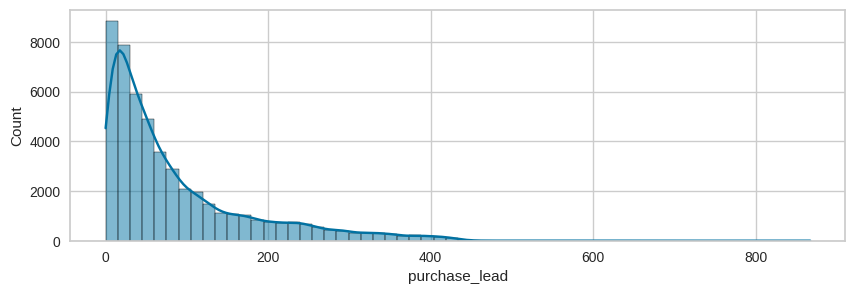

In [159]:
# image on purchase lead
plt.figure(figsize=(10,3))
sns.histplot(data=df, x="purchase_lead", binwidth=15,kde=True)
plt.show()

There are few bookings that were done more than 2 years before the travel date and it seems very unlikely that book that in advance. However, it might also be because of the cancellation and rebooking in a period of 6 months for twice. Generally airline keep the tickets for rebooking within a year. But at this point we will consider them as outliers which will effect the results of predictive model in a huge way.

In [160]:
# detecting outliers; more then 600 days
(df.purchase_lead >600).value_counts()

,count
purchase_lead,
False,49992
True,8


If we assume that no customer is booking in advance of more than 1 and half year we will remove all entries with purchase_lead more than 600 days.

In [161]:
# purchase lead more than 600 days
df[df.purchase_lead > 600]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
835,3,Internet,RoundTrip,641,46,6,Sun,AKLKUL,Malaysia,1,0,1,8.83,1
6148,1,Internet,RoundTrip,614,19,11,Wed,COKMEL,Australia,0,0,0,8.83,0
24119,1,Internet,RoundTrip,704,23,8,Tue,PNHSYD,Australia,0,0,0,8.58,0
38356,2,Internet,RoundTrip,633,5,10,Sat,HKTOOL,Australia,0,0,1,8.83,0
39417,1,Mobile,RoundTrip,625,5,15,Fri,ICNRGN,Myanmar (Burma),0,0,0,6.62,0
42916,1,Mobile,RoundTrip,605,6,18,Thu,BLRMEL,India,0,0,0,8.83,0
46716,2,Internet,RoundTrip,606,6,6,Fri,HKTTPE,United States,0,0,1,4.67,0
48259,3,Internet,RoundTrip,867,6,7,Mon,KIXMLE,Japan,0,0,1,7.00,1


In [162]:
# data to have only purchase lead days less than 600 days
df = df[df.purchase_lead <600 ]

### Length Of Stay

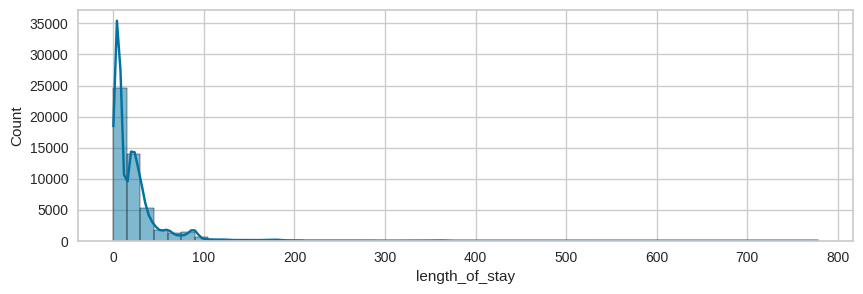

In [163]:
# how many days stay
plt.figure(figsize=(10,3))
sns.histplot(data=df, x="length_of_stay", binwidth=15,kde=True)
plt.show()

Let's see how many entries do we have that exceeds length of stay more than 100 days.

In [164]:
# count stay more than 100 days
(df.length_of_stay> 200).value_counts()

,count
length_of_stay,
False,49713
True,279


In [165]:
# detecting if the booking is complete where the length of stay is more than 500 days
df[df.length_of_stay> 500].booking_complete.value_counts()

,count
booking_complete,
0,9
1,1


We need to have more business knowledge to decide whether to remove these entries with more than 600 days of stay. There are could be many reasons for such bookings. But for now, we will just want to focus on bookings done for length of stay less than 500 days.

In [166]:
# filtering the data to have only length of stay days less than 500 days
df = df[df.purchase_lead <500 ]

### Flight Day

We will map the flight day with a number of a week.

In [167]:
mapping = {
    "Mon" : 1,
    "Tue" : 2,
    "Wed" : 3,
    "Thu" : 4,
    "Fri" : 5,
    "Sat" : 6,
    "Sun" : 7
}

df.flight_day = df.flight_day.map(mapping)

In [168]:
df.flight_day.value_counts()

,count
flight_day,
1,8100
3,7671
2,7670
4,7423
5,6759
7,6550
6,5809


**Note: Most of the customers want to travel on Monday and choose Saturday as least preffered day as flight day.**  

### Booking Origin

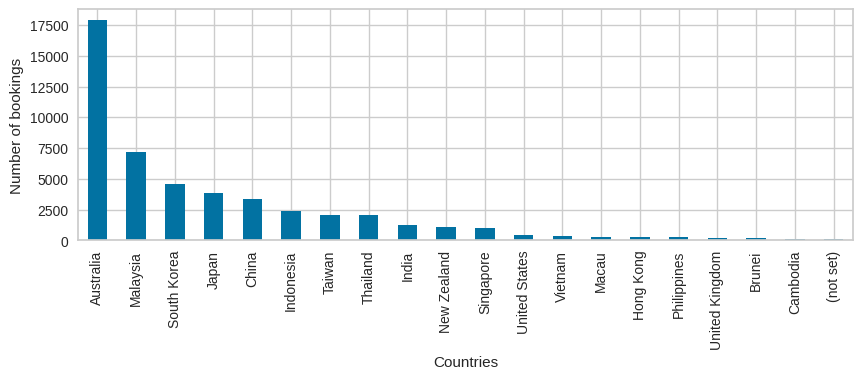

In [169]:
# country from where the booking happened
plt.figure(figsize=(10,3))
ax = df.booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of bookings")
plt.show()

**Australia** had maximum booking applications.

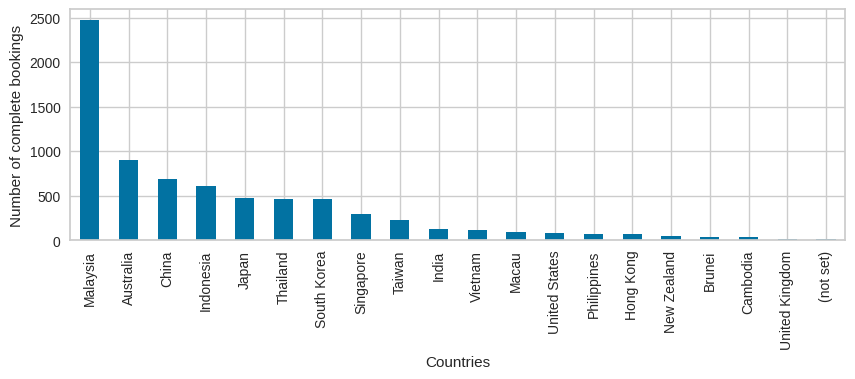

In [170]:
# Most booking complete
plt.figure(figsize=(10,3))
ax = df[df.booking_complete ==1].booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of complete bookings")
plt.show()

**Malaysia** had their booking complete.  

### Booking complete

In [171]:
# successful booking percentage
successful_booking_per = df.booking_complete.value_counts().values[0] / len(df) * 100

In [172]:
# unsuccessful booking percentage
unsuccessful_booking_per = 100-successful_booking_per

In [173]:
print(f"Out of 50000 booking entries only {round(unsuccessful_booking_per,2)} % bookings were successfull or complete.")

Out of 50000 booking entries only 14.96 % bookings were successfull or complete.


## Export the dataset to csv



In [174]:
df.to_csv("data/cleaned_and_filtered_customer_booking.csv")

### Predictive Model

In [175]:
# import data
df = pd.read_csv("data/cleaned_and_filtered_customer_booking.csv", index_col=0)

In [176]:
# setting index
df = df.reset_index(drop=True)

In [177]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49978,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49979,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49980,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [178]:
# one hot encoding to categorical data
df_final = df

# create instance of one hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')

# one hot encode Sales Channel
encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)

# one hot encode trip type
encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip',2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [179]:
# drop categorical columns now
df_final.drop(['sales_channel', 'trip_type','booking_origin', 'route'], axis=1, inplace = True)

In [180]:
# store the label for supervised learning
label = df['booking_complete']

In [181]:
df_final = df_final.drop('booking_complete', axis=1)

In [182]:
df_final

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip
0,2,262,19,7,6,1,0,0,5.52,1.0,0.0,0.0,0.0,1.0
1,1,112,20,3,6,0,0,0,5.52,1.0,0.0,0.0,0.0,1.0
2,2,243,22,17,3,1,1,0,5.52,1.0,0.0,0.0,0.0,1.0
3,1,96,31,4,6,0,0,1,5.52,1.0,0.0,0.0,0.0,1.0
4,2,68,22,15,3,1,0,1,5.52,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,27,6,9,6,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49978,1,111,6,4,7,0,0,0,5.62,1.0,0.0,0.0,0.0,1.0
49979,1,24,6,22,6,0,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49980,1,15,6,11,1,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0


### Normalizing Values

In [183]:
# create a standard scaler object
scaler = StandardScaler()

# fit and transform the data
scaled_df = scaler.fit_transform(df_final)

In [184]:
# create a dataframe of scled data
scaled_df = pd.DataFrame(scaled_df, columns = df_final.columns)

In [185]:
# add the labels back to the dataframe
scaled_df['label']  = label

In [186]:
scaled_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400769,1.971093,-0.119401,-0.381588,1.096876,0.703587,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,-0.579424,0.302987,-0.089895,-1.120618,1.096876,-1.421288,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,0.400769,1.759799,-0.030885,1.465988,-0.408618,0.703587,1.538334,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
3,-0.579424,0.125056,0.234662,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
4,0.400769,-0.186323,-0.030885,1.096473,-0.408618,0.703587,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,0.400769,-0.642272,-0.502969,-0.012073,1.096876,0.703587,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49978,-0.579424,0.291867,-0.502969,-0.935861,1.598707,-1.421288,-0.650054,-0.863557,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49979,-0.579424,-0.675634,-0.502969,2.389776,1.096876,-1.421288,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49980,-0.579424,-0.775721,-0.502969,0.357443,-1.412280,0.703587,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0


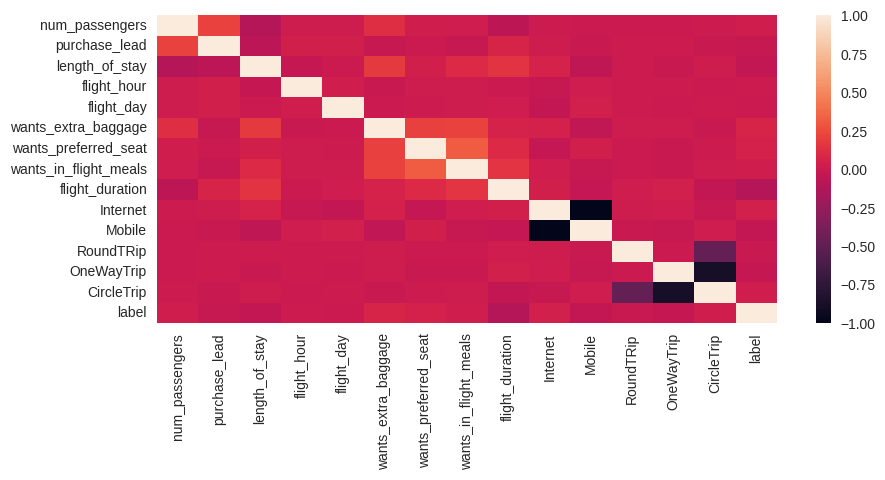

In [187]:
# correlation matrix
corr = scaled_df.corr()

#plot the heatmap
plt.figure(figsize=(10,4))
sns.heatmap(corr)
plt.show()

In [188]:
# Handle NaN values in 'label' column before train-test split

# Calculate the mean of the 'label' column (excluding NaN values)
mean_label = scaled_df['label'].mean()

# remove rows with NaN values in 'label'
scaled_df.dropna(subset=['label'], inplace=True)

# train-test split
X = scaled_df.iloc[:,:-1]
y = scaled_df['label']

# Convert y to integers before splitting
#y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [189]:
# Create functions to fit and predict the values; whether customer would complete the booking or not
# Functions with metrics to evaluate the model prediction

def model_fit_predict(model, X, y, X_predict):
  """
  Will fit the model and predict the values

  Parameters
  ----------
  model: input model
  X: training input
  y: training output
  X_predict: testing input

  Returns
  -------
  model prediction
  """
  model.fit(X, y)
  return model.predict(X_predict)

def acc_score(y_true, y_pred):
  """
  Calculate the accuracy score

  Parameters
  ----------
  y_true: actual values
  y_pred: predicted values

  Returns
  -------
  accuracy score
  """
  return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
  """
  Calculate the precision score

  Parameters
  ----------
  y_true: actual values
  y_pred: predicted values

  Returns
  -------
  precision score
  """
  return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
  """
  Calculate the f1 score

  Parameters
  ----------
  y_true: actual values
  y_pred: predicted values

  Returns
  -------
  f1 score
  """
  return f1_score(y_true, y_pred)

### Random Forset

In [190]:
# create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

In [191]:
# check training accuracy
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

#f1 score for training data
f1 = round(f1_score(y_train, y_pred_train),2)

#accuracy score for training data
acc = round(accuracy_score(y_train, y_pred_train),2)

#precision score for training data
pre = round(precision_score(y_train, y_pred_train),2)

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.93, 1.0 and 0.72 respectively


0.9341002876078529

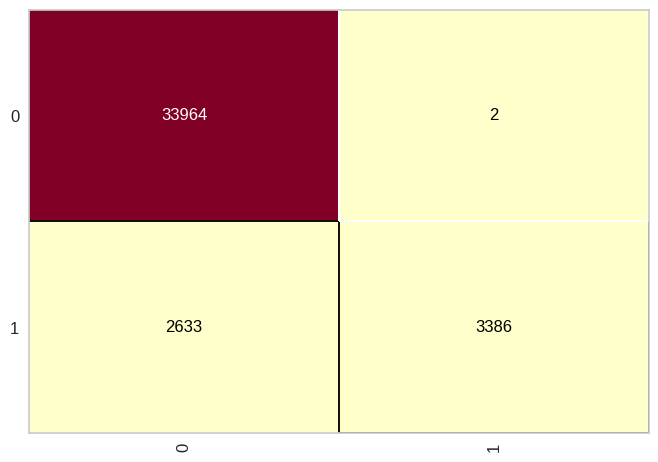

In [192]:
# confusion matrix
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_train, y_train)

In [193]:
# testing accuracy
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2)

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2)

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2)

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.86, 0.56 and 0.07 respectively


0.8554566369910973

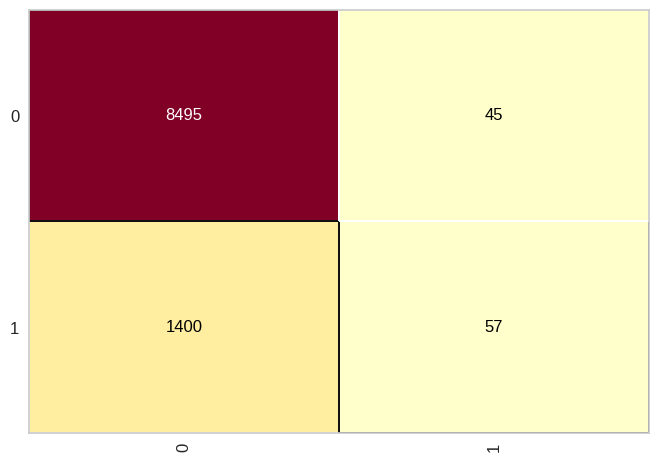

In [194]:
# confusion matrix
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

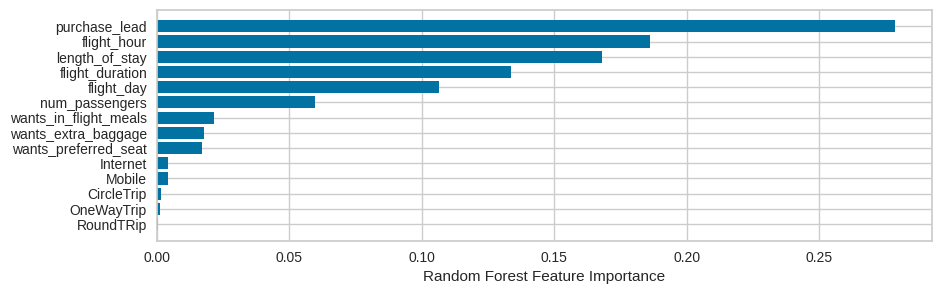

In [195]:
# important features
plt.figure(figsize=(10,3))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig("feature_importance.png", dpi=300)
plt.show()

**Note:** One major problem behind getting low F1 score is imbalanced dataset. We have higher entries that are classified 0 than 1. We could reduce the number of entries that are classified 0 to be equal around the number of entries that are classified as 1.

### Balance Datasheet

In [196]:
scaled_df.label.value_counts()

,count
label,
0,42506
1,7476


In [208]:
# create a dataframe having all labels 0 with 10000 samples
scaled_df_0 = scaled_df[scaled_df.label ==0].sample(n=7476)

In [209]:
# oncatenate the two dataframee, one havng all labels 0 and other having all labels as 1
scaled_df_new = pd.concat([scaled_df[scaled_df.label==1], scaled_df_0], ignore_index=True)

In [210]:
#shuffle the dataframe rows
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)

In [211]:
scaled_df_new

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,-0.579424,-0.853566,-0.620990,0.172685,0.093214,0.703587,-0.650054,1.158002,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,0.400769,1.681955,0.175652,-0.751103,1.598707,0.703587,-0.650054,1.158002,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
2,0.400769,-0.575548,-0.532474,0.357443,-0.408618,-1.421288,-0.650054,-0.863557,-1.708517,-2.810681,2.810681,-0.048231,-0.088336,0.100826,1
3,-0.579424,3.794888,-0.561979,0.911715,1.096876,0.703587,-0.650054,-0.863557,-0.632900,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
4,-0.579424,-0.898048,-0.060390,-0.566346,1.598707,0.703587,-0.650054,-0.863557,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14947,-0.579424,-0.097358,-0.532474,-0.566346,0.595045,0.703587,1.538334,-0.863557,-1.635028,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
14948,0.400769,1.481782,-0.030885,0.911715,1.598707,0.703587,1.538334,1.158002,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
14949,-0.579424,-0.753479,-0.502969,-0.012073,-0.408618,-1.421288,1.538334,-0.863557,0.195526,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
14950,0.400769,1.504023,-0.591484,0.172685,0.093214,-1.421288,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0


In [212]:
scaled_df_new.label.value_counts()

,count
label,
0,7476
1,7476


In [213]:
# train test
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [214]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [215]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2)

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2)

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2)

recall = round(recall_score(y_test, y_pred_test),2)

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

print(f"Accuracy, precision, recall and f1-score for training data are {acc}, {pre}, {recall}, and {f1} respectively")

Accuracy, precision, recall and f1-score for training data are 0.62, 0.62, 0.63, and 0.62 respectively


0.6232029421598128

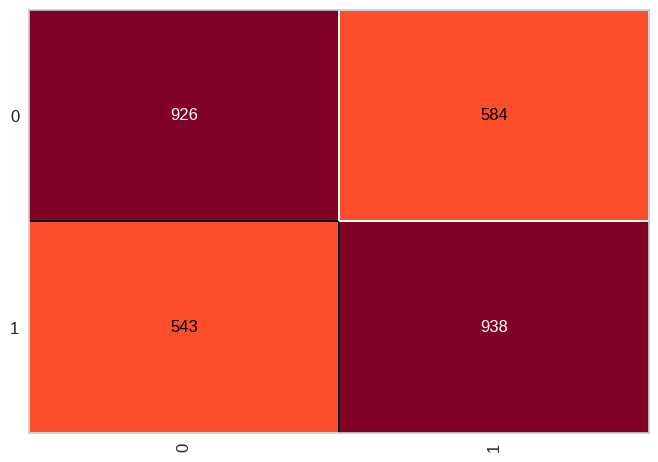

In [216]:
# confusion matrix
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

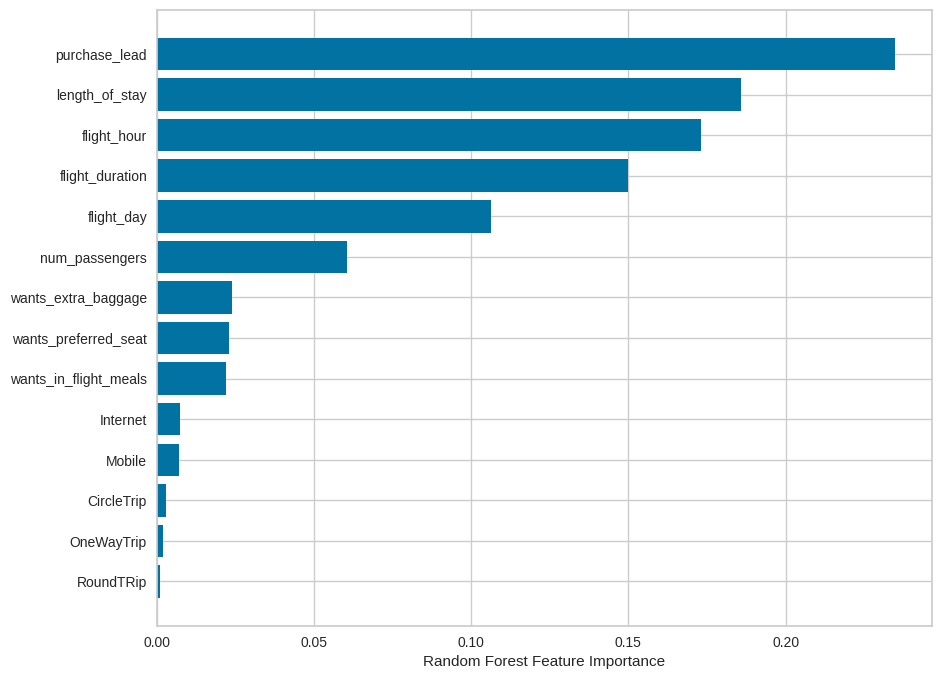

In [217]:
# feature importances
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig("feature_importance_scaled.png", dpi=300)
plt.show()